<a href="https://colab.research.google.com/github/hawkeyedatatsai/MLB-Stadiums/blob/main/MLB_Stadiums.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch

#Data Dictionary

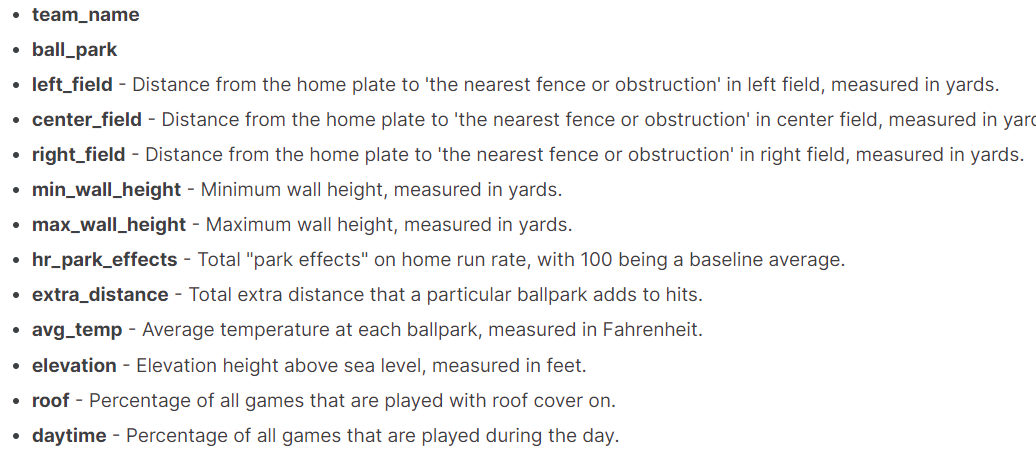

In [2]:
filename = "/content/ballparks.csv"
df = pd.read_csv(filename)
print(df.info())
print(df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   team_name        30 non-null     object 
 1   ballpark         30 non-null     object 
 2   left_field       30 non-null     int64  
 3   center_field     30 non-null     int64  
 4   right_field      30 non-null     int64  
 5   min_wall_height  30 non-null     float64
 6   max_wall_height  30 non-null     int64  
 7   hr_park_effects  30 non-null     int64  
 8   extra_distance   30 non-null     float64
 9   avg_temp         30 non-null     float64
 10  elevation        30 non-null     int64  
 11  roof             30 non-null     float64
 12  daytime          30 non-null     float64
dtypes: float64(5), int64(6), object(2)
memory usage: 3.2+ KB
None
(30, 13)


,team_name,ballpark,left_field,center_field,right_field,min_wall_height,max_wall_height,hr_park_effects,extra_distance,avg_temp,elevation,roof,daytime
0,ATL,Truist Park,335,400,325,11.0,15,99,1.8,79.2,1001,0.00,0.31
1,AZ,Chase Field,328,407,335,7.6,25,84,13.2,80.8,1086,0.81,0.31
2,BAL,Oriole Park at Camden Yards,333,400,318,7.0,21,107,-0.5,76.4,33,0.00,0.35
3,BOS,Fenway Park,310,420,302,3.0,37,102,-4.7,69.5,21,0.00,0.31
4,CHC,Wrigley Field,355,400,353,11.5,15,97,-3.4,70.2,595,0.00,0.55


In [3]:
df.duplicated().sum()
#suggest no duplicate

0

In [4]:
df.isna().sum()

team_name          0
ballpark           0
left_field         0
center_field       0
right_field        0
min_wall_height    0
max_wall_height    0
hr_park_effects    0
extra_distance     0
avg_temp           0
elevation          0
roof               0
daytime            0
dtype: int64

In [5]:
#check for inconsistent values in categorical columns
for col in list(df.select_dtypes(include='number')):
  print(col)
  print(df[col].value_counts())
  print()

left_field
330    5
328    3
336    3
335    2
325    2
315    2
344    2
339    2
329    2
333    1
310    1
355    1
347    1
345    1
318    1
331    1
Name: left_field, dtype: int64

center_field
400    7
404    4
407    3
420    2
405    2
396    2
408    2
399    2
415    1
409    1
410    1
395    1
401    1
402    1
Name: center_field, dtype: int64

right_field
330    7
335    5
325    3
326    2
328    2
322    2
318    1
302    1
353    1
350    1
345    1
314    1
320    1
327    1
309    1
Name: right_field, dtype: int64

min_wall_height
8.0     13
7.0      4
9.0      4
6.0      2
11.0     1
7.6      1
3.0      1
11.5     1
5.0      1
4.5      1
4.0      1
Name: min_wall_height, dtype: int64

max_wall_height
8     9
15    3
21    3
12    3
25    2
9     2
37    1
19    1
17    1
23    1
13    1
10    1
11    1
14    1
Name: max_wall_height, dtype: int64

hr_park_effects
99     2
97     2
114    1
108    1
89     1
82     1
81     1
95     1
87     1
116    1
76     1
113   

In [6]:
df.describe()
#max elevation 5190 seems odd 
#BUT we know how Coors Field is high and far from the ground

,left_field,center_field,right_field,min_wall_height,max_wall_height,hr_park_effects,extra_distance,avg_temp,elevation,roof,daytime
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,331.833333,404.166667,328.333333,7.553333,14.266667,100.500000,-0.030000,73.480000,517.466667,0.185333,0.383333
std,9.857898,6.264753,10.459555,1.797265,7.060982,16.812865,5.966004,3.943602,948.785384,0.350917,0.086715
min,310.000000,395.000000,302.000000,3.000000,8.000000,75.000000,-7.700000,63.800000,0.000000,0.000000,0.240000
25%,328.000000,400.000000,325.000000,7.000000,8.000000,88.250000,-3.700000,71.300000,21.500000,0.000000,0.320000
50%,330.000000,404.000000,329.000000,8.000000,12.000000,99.000000,-1.250000,73.350000,365.000000,0.000000,0.380000
75%,336.000000,407.000000,333.750000,8.000000,18.500000,111.750000,1.250000,76.475000,599.250000,0.120000,0.417500
max,355.000000,420.000000,353.000000,11.500000,37.000000,150.000000,22.000000,80.800000,5190.000000,1.000000,0.610000


In [7]:
#decide to put team and ballpark name to index
#drop roof since not many teams' stadium hv roof option so I dont think that col
#can speak much for the whole dataset
new_df = df.groupby(['team_name', 'ballpark']).sum()
new_df = new_df.drop('roof', axis=1)
print(new_df.info())
new_df.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30 entries, ('ATL', 'Truist Park') to ('WSH', 'Nationals Park')
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   left_field       30 non-null     int64  
 1   center_field     30 non-null     int64  
 2   right_field      30 non-null     int64  
 3   min_wall_height  30 non-null     float64
 4   max_wall_height  30 non-null     int64  
 5   hr_park_effects  30 non-null     int64  
 6   extra_distance   30 non-null     float64
 7   avg_temp         30 non-null     float64
 8   elevation        30 non-null     int64  
 9   daytime          30 non-null     float64
dtypes: float64(4), int64(6)
memory usage: 3.0+ KB
None


,,left_field,center_field,right_field,min_wall_height,max_wall_height,hr_park_effects,extra_distance,avg_temp,elevation,daytime
team_name,ballpark,,,,,,,,,,
ATL,Truist Park,335,400,325,11.0,15,99,1.8,79.2,1001,0.31
AZ,Chase Field,328,407,335,7.6,25,84,13.2,80.8,1086,0.31
BAL,Oriole Park at Camden Yards,333,400,318,7.0,21,107,-0.5,76.4,33,0.35
BOS,Fenway Park,310,420,302,3.0,37,102,-4.7,69.5,21,0.31
CHC,Wrigley Field,355,400,353,11.5,15,97,-3.4,70.2,595,0.55


#Clustering

##Elbow Point

In [8]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(new_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'inertia')

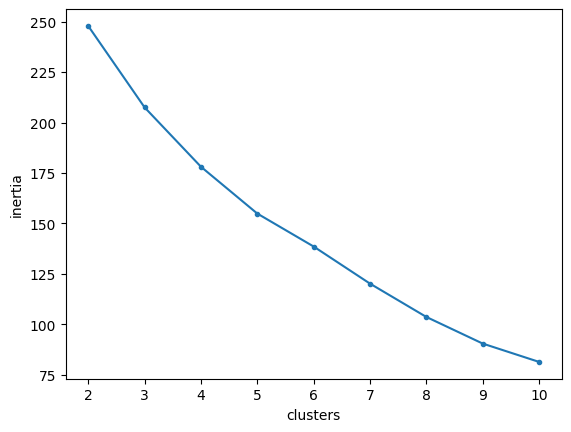

In [9]:
#cluster-elbow plot
#Create an empty list of inertias
inertias = []
#Loop through k values between 2 and 10 and store the inertias in the list.
for k in range(2,11):
    kmeans = KMeans(n_clusters=k)  
    kmeans.fit(scaled_df)  
    inertias.append(kmeans.inertia_)
#Visualize scores
plt.plot(range(2,11), inertias, marker = '.')
plt.xlabel('clusters')
plt.ylabel('inertia')

##Silhouette Score

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

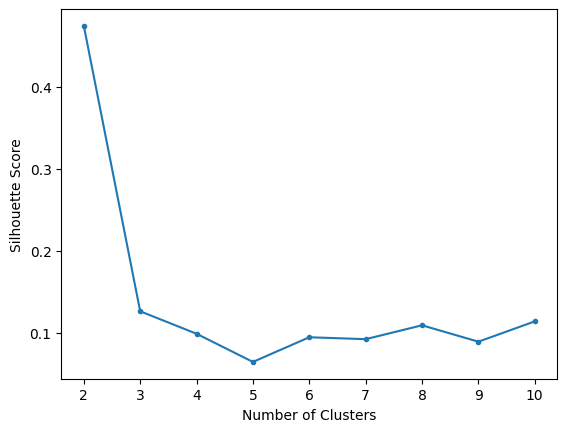

In [10]:
silhouette_scores = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(scaled_df)
  silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_))
# Visualize scores
plt.plot(range(2, 11), silhouette_scores, marker = '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

##PCA

<ipython-input-11-a5a87e84d043>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


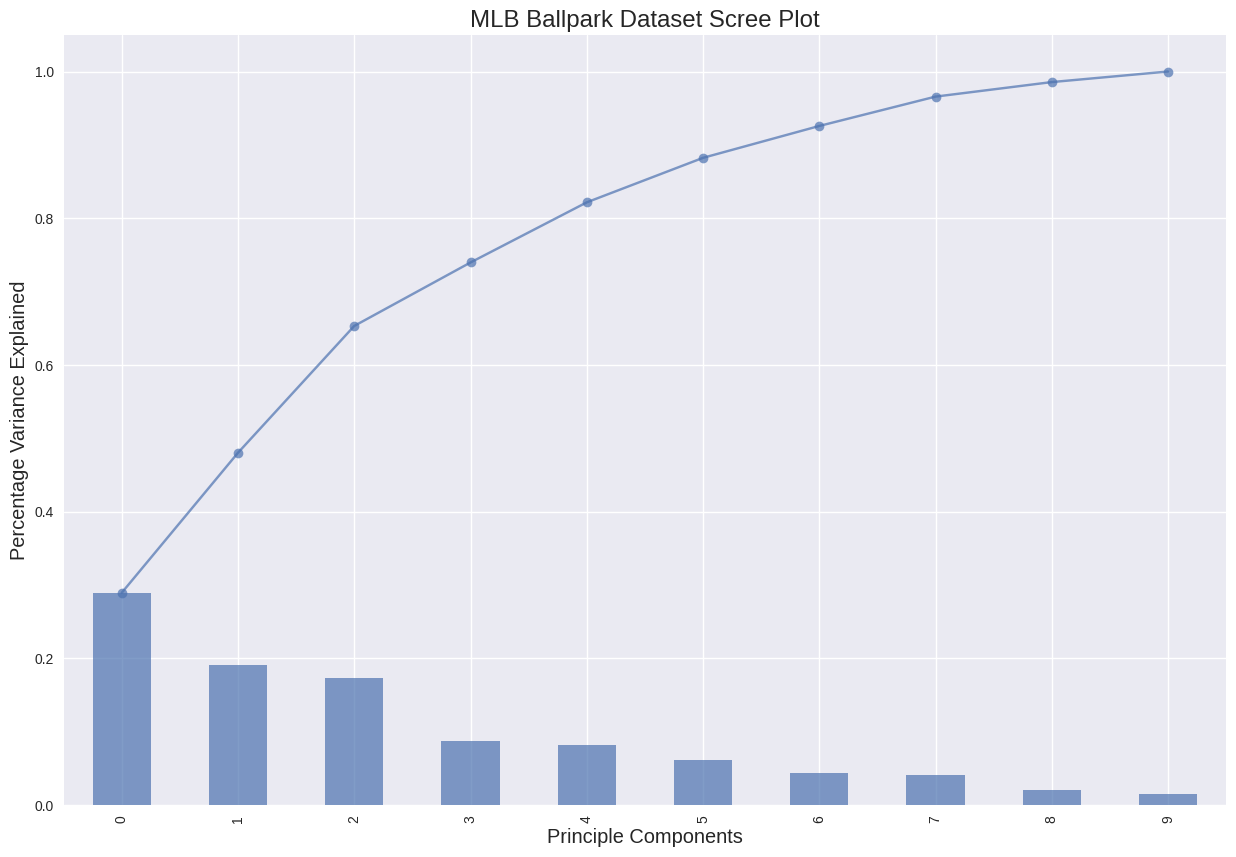

In [11]:
pca=PCA()
pca.fit_transform(scaled_df)
# Scree plot
# Lets visual the cummulative sum of the variances 

plt.style.use("seaborn")
plt.figure(figsize=(15,10))
exp_var = pd.Series(pca.explained_variance_ratio_)

# Plot the variance for each component
exp_var.plot(kind="bar", alpha=0.7) # plot bar chart

# Calculate the amount of variance explained added by each additional component
total = 0
var_ls = []
for x in exp_var:
    total = total+x
    var_ls.append(total)
    
# Plot line chart of increasing variances
pd.Series(var_ls).plot(marker="o", alpha=0.7) 

# Plot labels and titles
plt.xlabel("Principle Components", fontsize="x-large")
plt.xticks(rotation=90)
plt.ylabel("Percentage Variance Explained", fontsize="x-large")
plt.title("MLB Ballpark Dataset Scree Plot", fontsize="xx-large")
plt.show();

In [12]:
#decide to select PCA with 6 components, we will only use 60% (6/10) of features 
#but still receive almost 90% effect
pca6 = PCA(n_components=6)

###Hierarchical Clustering

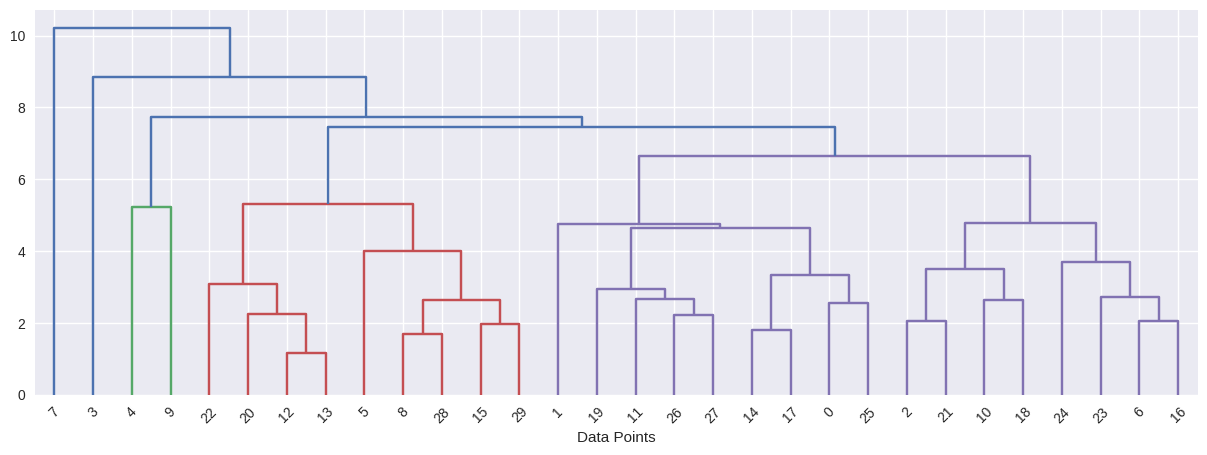

In [15]:
# Visualize Dendogram
plt.figure(figsize = (15, 5))
sch.dendrogram(sch.linkage(scaled_df, method = 'ward'))
plt.xlabel('Data Points');

#Exploratory Data

##Univariate visualizations

In [ ]:
#Strategy
#stroke, hypertension and heart_disease are binary variable -> pie chart
#categorial data -> barplot
#numercial data -> histogram

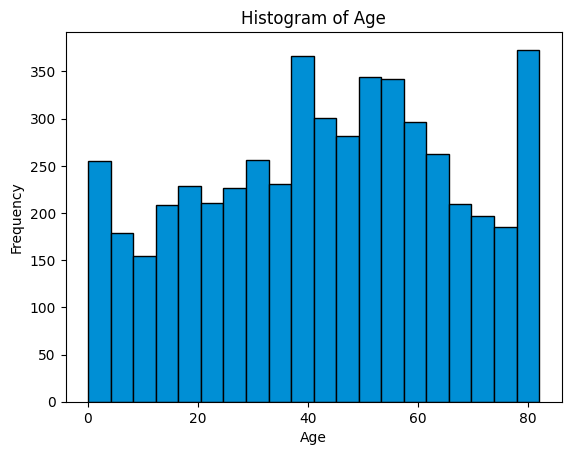

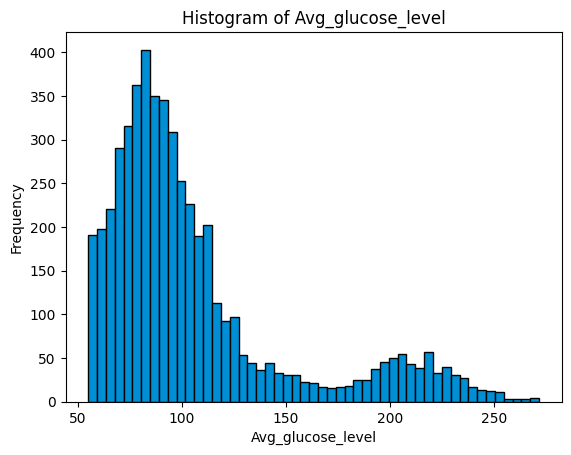

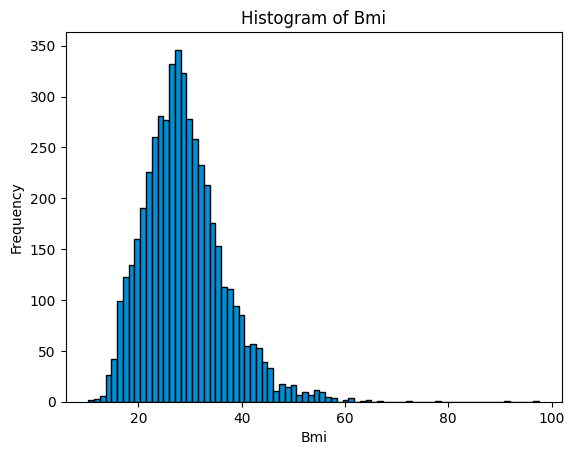

In [ ]:
#create histograms for each numerical column
for col in ['age', 'avg_glucose_level', 'bmi']:
    plt.hist(df[col], bins="auto", color='#008fd5', edgecolor="black")
    plt.xlabel(col.capitalize())
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col.capitalize()}')
    plt.show()

From countplot above, it is observed that the following characters have more stroke in its feature.

- female
- married
- living at urban
- working in private sector
- never smoked

##Multivariate visualizations

I intend to explore more with age since it has the highest correlation with stroke.

###Scatter Plot

Text(0, 0.5, 'BMI')

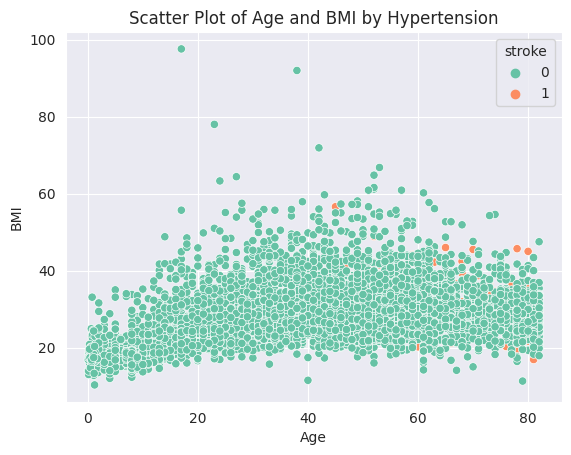

In [ ]:
sns.set_style('darkgrid')
sns.scatterplot(y ='bmi', x = 'age', data = df, hue = 'stroke', palette='Set2')
plt.title('Scatter Plot of Age and BMI by Hypertension')
plt.xlabel('Age')
plt.ylabel('BMI')
#Interested to see what its like if i can separate 0 and 1 stroke

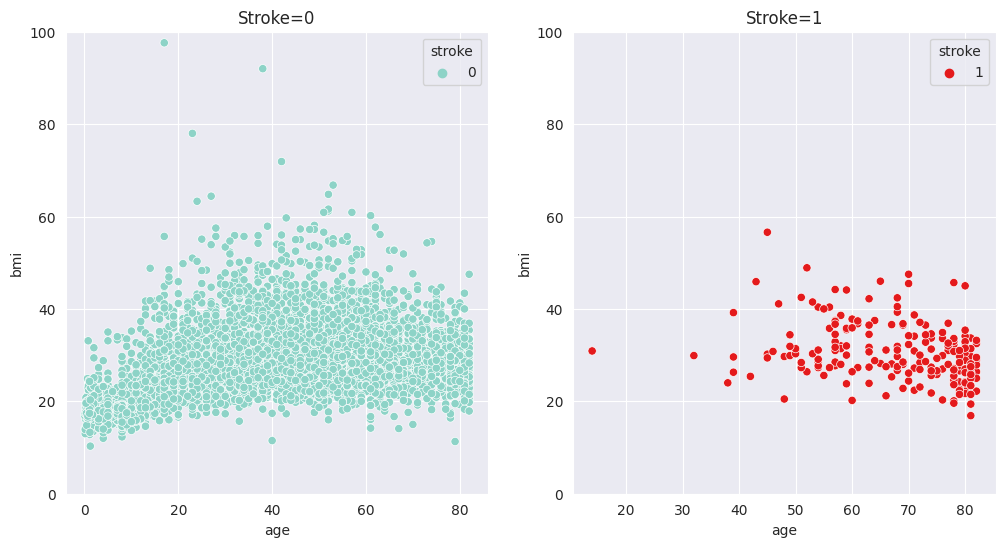

In [ ]:
#dataframes for stroke=0 and 1 individually
df_stroke_0 = df[df['stroke'] == 0]
df_stroke_1 = df[df['stroke'] == 1]

#set up the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

#scatterplot for stroke=0
sns.scatterplot(ax=ax1, x='age', y='bmi', data=df_stroke_0, hue='stroke', palette='Set3')
ax1.set_title('Stroke=0')

#scatterplot for stroke=1
sns.scatterplot(ax=ax2, x='age', y='bmi', data=df_stroke_1, hue='stroke', palette='Set1')
ax2.set_title('Stroke=1')

#set y-limits for both plots to be the same scale
ax1.set_ylim(0, 100)
ax2.set_ylim(0, 100)

plt.show()


###Bar Plot

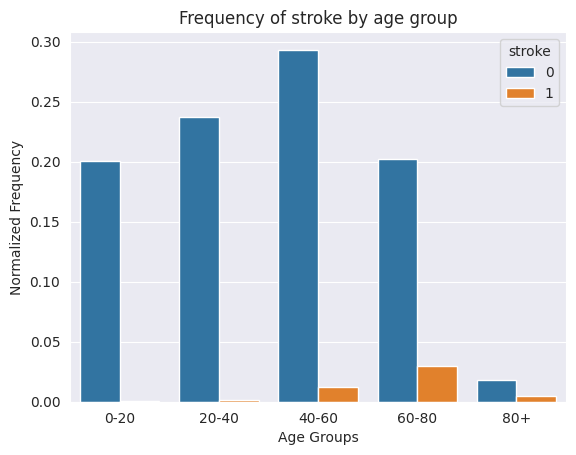

In [ ]:
#create age groups
df['age_group'] = pd.cut(df['age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '20-40', '40-60', '60-80', '80+'])

count_data = df.groupby(['age_group', 'stroke']).size().reset_index(name='count')

# Calculate the total count of observations
total_count = count_data['count'].sum()

# Normalize the counts
count_data['normalized_count'] = count_data['count'] / total_count

# Create the countplot with normalized y-axis values
sns.barplot(x='age_group', y='normalized_count', hue='stroke', data=count_data)
plt.title('Frequency of stroke by age group')
plt.xlabel('Age Groups')
plt.ylabel('Normalized Frequency')

plt.show()

###Line Plot

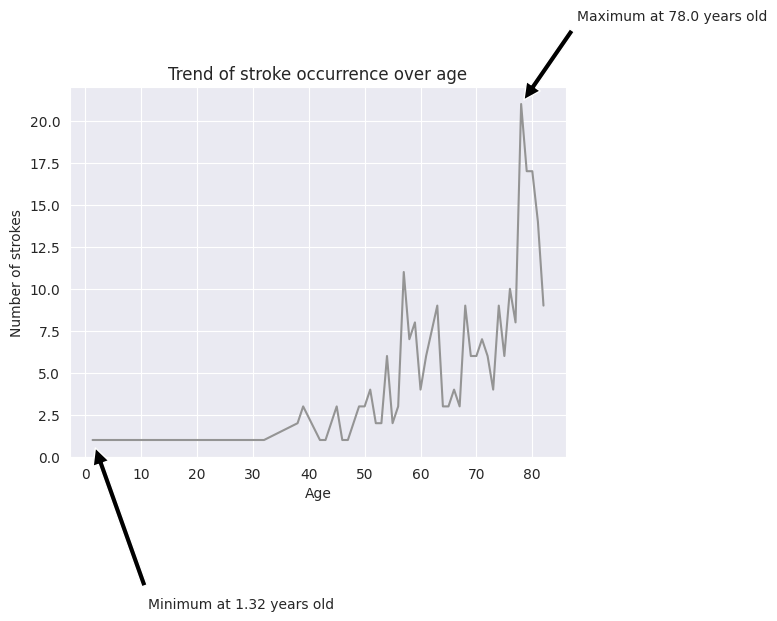

In [ ]:
#grouby age and stroke count data
age_stroke_counts = df[df['stroke']==1].groupby(['age'])['stroke'].count().reset_index(name='count')

#plot the line
plt.plot(age_stroke_counts['age'], age_stroke_counts['count'], color=sns.color_palette("colorblind")[7])

#add annotation for the highest count
max_count = age_stroke_counts['count'].max()
max_count_age = age_stroke_counts[age_stroke_counts['count']==max_count]['age'].values[0]
plt.annotate(f'Maximum at {max_count_age} years old', xy=(max_count_age, max_count), xytext=(max_count_age+10, max_count+5), 
             arrowprops=dict(facecolor='black', shrink=0.05))


#get age with the minimum stroke count
min_count = age_stroke_counts['count'].min()
min_count_age = age_stroke_counts[age_stroke_counts['count'] == min_count]['age'].values[0]
plt.annotate(f'Minimum at {min_count_age} years old', xy=(min_count_age, min_count), xytext=(min_count_age+10, min_count-10), 
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.xlabel('Age')
plt.ylabel('Number of strokes')
plt.title('Trend of stroke occurrence over age')

plt.show()


###Summary



*   From scatterplots , it is shown that strokes occurs on older population especially after 50 years old.

*   Bar chart above suggest most of the stroke patient are within the age group of 60 to 80 years old.

*   Line plot suggests the trend of stroke occurrence throughout different age. It is observed that there is a spike on mid to late 50s, also found that most of ppl with stroke is on age of 78.







